## Stereographic dilation and slip tendency analsysis

This notebook contains functions for constructing arbitrary stress tensors and resolving them onto planes (based on the orientation of their normal vector) to derive traction vectors (in plane-parallel and plane-perpendicular directions). These traction components are then used to compute the dilation and slip tendency of all possible plane orientations (for a given stress field), and plots these on a stereonet, accompanied by fracture data from the Puga geothermal system. 

These plots indicate which of these pre-existing fractures have orientations favourable for fluid flow under the assumed stress field. 

### *Dependencies:*

This notebook uses standard scientific python libraries (pandas, matplotlib, numpy and scipy), as well as the mplstereonet extension for plotting stereonets using matplotlib.

### *Reference:*

For more information about this study, please refer to the accompanying paper:

>Thiele, S.T., Zimik, H.V., Samsu, A., Akhtar, S., Kamath, A.V., Khanna, P., In Prep. Outcrop analogue constraints on subsurface reservoir properties of the Puga geothermal field, NW Himalaya. *Journal TBD*.

Please also cite this paper if our code is useful for your work. And don't hesitate to reach out if you have questions 🚀

**Author:** *Sam Thiele* </br>
**Date:** *23.11.2023* 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplstereonet
import matplotlib as mpl
from scipy.spatial.transform import Rotation

np.float = np.float32 # nasty hack to get mplstereo working with this version of numpy

In [2]:
#setup figure styles
plt.style.use(['default'])
mpl.rcParams['font.size'] = 15
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

Load datasets

In [3]:
data = {}
for d in 'ABCDEF':
    df = pd.read_csv('data/planes_%s.csv'%d)
    data[d] = np.array( [df['Strike'], df['Dip'], df['Length']] ) # load strike and dip

In [4]:
print("%d measurements"%sum([len(data[d][0]) for d in 'ABCDEF'] ))

533 measurements


Plot stereonet of all fractures

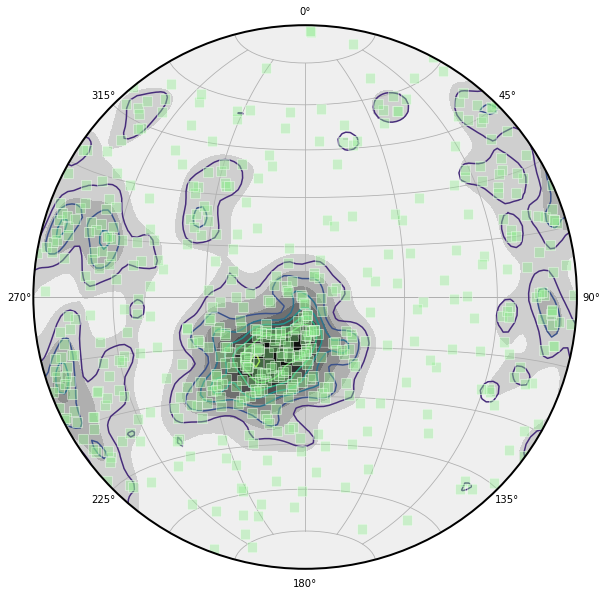

In [5]:
fig,a = mplstereonet.subplots(1,1,figsize=(10,10))
strike = np.hstack([data[d][0] for d in 'ABCDEF'])
dip = np.hstack([data[d][1] for d in 'ABCDEF'])
length = np.hstack([data[d][2] for d in 'ABCDEF'])

cax = a.density_contourf(strike, dip, measurement='poles', cmap='gray_r', sigma=3)
a.density_contour(strike, dip, measurement='poles', sigma=2)
a.pole(strike, dip, color='w', marker='s', markersize=10, mfc='lightgreen', alpha=0.4)
a.grid()

Plot a stereonet of each specific site

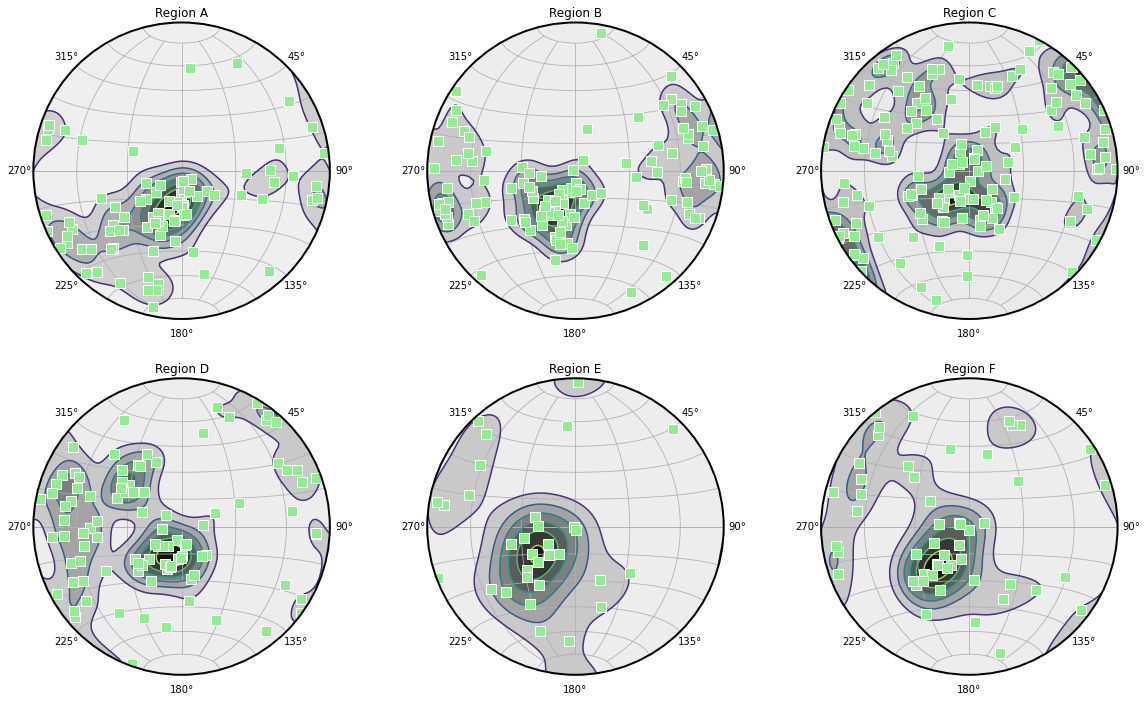

In [6]:
fig,ax = mplstereonet.subplots(2,3,figsize=(20,12))

for a,d in zip(ax.ravel(),'ABCDEF'):
    cax = a.density_contourf(data[d][0], data[d][1], measurement='poles', cmap='gray_r', sigma=2)
    a.density_contour(data[d][0], data[d][1], measurement='poles', sigma=2)
    a.pole(data[d][0], data[d][1], color='w', marker='s', markersize=10, mfc='lightgreen')
    a.set_azimuth_ticks(np.linspace(0,360,9)[1:-1])
    a.grid()
    a.set_title("Region %s"%( d) )
    
for a in ax.ravel():
    a._polar.set_position(a.get_position())

**Dilation tendency analysis**: resolve stress tensor (derived using orientation from conjugate faults and an assumed stress ratio) onto these planes to identify those with orientations favourable for fluid flow (hight dilation or slip tendency).

In [7]:
def trendPlunge2Vec(trend : np.ndarray , plunge : np.ndarray):
    """
    Convert a trend and plunge measurement to a cartesian vector.
    **Arguments**:
       -trend = the trend of the vector to transform. 0 < trend < 2* pi
       -plunge = the plunge of the vector to transform. 0 < plunge < pi / 2
    **Returns:
    -xyz = a numpy array represeting the vector.
    """
    
    return np.array( [np.sin(trend) * np.cos(plunge),
                      np.cos(trend) * np.cos(plunge),
                      -np.sin(plunge)])


def vec2TrendPlunge(xyz):
    """
    Convert a vector to a trend and plunge.

    **Arguments**:
     - xyz = a numpy array of length (n,3) containing the vector to convert.
    **Returns**:
     - trend = the trend of the vector (in radians)
     - plunge = the plunge of the vector (in radians)
    """
    if len(xyz.shape) == 1:
        xyz = xyz[:,None]
        
    out = np.zeros( (2, xyz.shape[1]) )
    out[0,:] =  np.arctan2( xyz[0,:], xyz[1,:] )
    out[1,:] = -np.arcsin(xyz[2,:])
    
    # map to correct domain
    mask = out[1,:] < 0 
    out[0,mask ] = np.arctan2(-xyz[0,mask],-xyz[1,mask])
    out[1,mask ] = -np.arcsin(-xyz[2,mask])
    
    while (out[0,:] < 0).any():
        out[ 0, out[0,:] < 0 ] += 2 * np.pi
    
    return out

def getStress( T1, P1, P2, R ):
    """
    Generate a stress tensor with the desired orientation and stress ratio.
    
    :param T1: The trend of the maximum principal compressive strength (S1).
    :param P1: The plunge of the maximum principal compressive strength (S1).
    :param P2: The rake of the intermediate principal stress (S2) in the plane normal to S1
    :param R: The desired stress ratio. Note that 0 < R < 1.
    """

    # N.B. This is a fairly ugly way to do this; but... I hate rotations!
    S1 = trendPlunge2Vec( np.deg2rad(T1), np.deg2rad(P1) )
    S2 = np.cross( [0.,0.,1.], S1 ) # compute S2 with zero rotation (horizontal)
    S2 /= np.linalg.norm(S2)
    S2 = Rotation.from_rotvec( np.deg2rad(P2) * S1 ).apply(S2) # rotate it according to P2
    S3 = np.cross(S1, S2) # compute S3 as perpendicular to S1 and S2
    S3 /= np.linalg.norm(S3)
    
    # define eigenvalues (principal stress magnitudes) that match stress ratio R
    s = np.array( [2, R+1, 1] ) # generate principal stress magnitudes to match R value
    s /= np.linalg.norm(s) # not needed, but nice
    assert np.abs( (s[1] - s[2]) / (s[0] - s[2]) - R ) < 1e-6, "We have a problem with R"
    
    
    # assemble stress tensor
    M = s * np.eye(3) # eigenvalues
    S = np.vstack([S1*s[0], S2 * s[1], S3 * s[2]]).T # principal stress basis
    return S @ M @ np.linalg.inv(S) # return our stress tensor

def setPrincipalStress( S1, S2, S3, R ):
    """
    Construct a (unitless) stress tensor from principal stress vectors (S1, S2 and S3) and a stress ratio.
    """
    
    # define eigenvalues (principal stress magnitudes) that match stress ratio R
    s = np.array( [2, R+1, 1] ) # generate principal stress magnitudes to match R value
    s /= np.linalg.norm(s) # not needed, but nice
    assert np.abs( (s[1] - s[2]) / (s[0] - s[2]) - R ) < 1e-6, "We have a problem with R"
    
    # assemble stress tensor
    M = s * np.eye(3) # eigenvalues
    S = np.vstack([S1*s[0], S2 * s[1], S3 * s[2]]).T # principal stress basis
    return S @ M @ np.linalg.inv(S) # return our stress tensor
    
def getPrincipalStress( S ):
    """
    Get principal stress vectors and magnitudes from a stress tensor using eigenvalue decomposition.
    
    :param S: The (3,3) stress tensor.
    :returns: An array of shape (3,) containing the principal stresses and (3,3) with principal
              stress directions in the columns.
    """
    e,v = np.linalg.eig(S)
    idxx = np.argsort(e)[::-1]
    return e[idxx], v[:, idxx]
    
    
def getTraction( stress, normals ):
    """
    Get the traction vectors on a set of planes, for a given stress tensor.
    
    :param stress: A (3,3) stress tensor to resolve onto the planes.
    :param normals: A (3,n) array of normal vectors to resolve the stress onto
    :returns: A (3,n) array of traction vectors on each plane.
    """
    if len(normals.shape) == 1:
        normals = normals[:, None ]
        
    return stress @ normals # easy!

def getTraction2( stress, normals ):
    """
    Get the tractions on a set of planes, for a given stress tensor, but resolved
    into a slip vector (parallel to each plane) and normal vector (perpendicular to each plane).
    
    :param stress: A (3,3) stress tensor to resolve onto the planes.
    :param normals: A (3,n) array of normal vectors to resolve the stress onto
    :returns: The normal and shear forces on the plane
    """
    if len(normals.shape) == 1:
        normals = normals[:, None ]
        
    T = getTraction(stress, normals)
    N = normals*np.einsum('ij, ij->i', T.T, normals.T) # normal component of traction
    S = T - N # shear component of traction
    return N, S

Use the above functions to construct a stress tensor for Puga

In [8]:
# construct stress tensor
S1 = trendPlunge2Vec( np.deg2rad(283), np.deg2rad(88) ) # sigma 1 direction
S2 = trendPlunge2Vec( np.deg2rad(42), np.deg2rad(2) ) # sigma 2 direction
S2 -= np.dot(S1,S2)*S1 # ensure it is perpendicular to S1 [ due to rounding errors etc. ] 
S2 /= np.linalg.norm(S2)
S3 = np.cross(S1, S2)

#N.B. we use a stress ratio of 0.75 here, as Ladakh is likely between extensional and transpressional
stress = setPrincipalStress(S1,S2,S3,0.75) 

# convert back to principal stresses and stress magnitudes
(S1,S2,S3), P = getPrincipalStress(stress) # get principal stresses

Compute and plot dilation and slip tendency

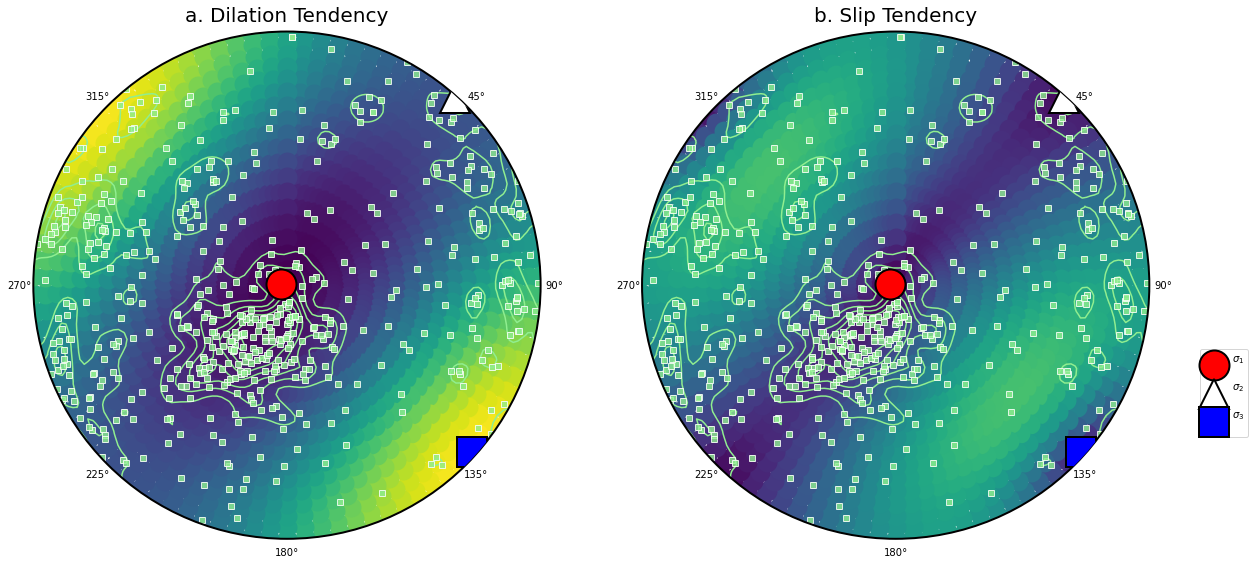

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121, projection='stereonet')
ax2 = fig.add_subplot(122, projection='stereonet')

for t in np.linspace(0, 360, 91):
    for p in np.linspace(0, 90, 19):
        # compute dilation tendency and thus colour
        n = trendPlunge2Vec( np.deg2rad(t), np.deg2rad(p) )
        ctn,cts = getTraction2( stress, n ) # get tractions
        cn = np.linalg.norm(ctn, axis=0) # resolve their magnitudes
        cs = np.linalg.norm(cts, axis=0) 
        cTs = cs / cn # slip tendency
        cTd = (S1 - cn) / (S1 - S3) # dilation tendency

        # plot
        cmap = mpl.colormaps['viridis']
        ax1.line(p, t, marker='o', color=cmap(cTd), markersize=20, markeredgewidth=0, zorder=1)
        ax2.line(p, t, marker='o', color=cmap(2*cTs), markersize=20, markeredgewidth=0, zorder=1)
        
ax1.set_title("a. Dilation Tendency", pad=10, fontsize=20)
ax2.set_title("b. Slip Tendency", pad=10, fontsize=20)
for a in [ax1, ax2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_azimuth_ticks([])

    # add in dykes and veins
    cmap = mpl.colormaps['tab20']
    
    # add principal stresses
    for i,l in enumerate(['$\sigma_1$\n', '$\sigma_2$\n','$\sigma_3$\n']):
        _t,_p = np.rad2deg( vec2TrendPlunge( P[:,i] ) )
        a.line(_p, _t, marker='o^s'[i], color=['r','white','b'][i], markersize=30, 
                            markeredgewidth=2, markeredgecolor='k', label=l , zorder=3)
    
    # plot fractures
    a.density_contour(strike, dip, measurement='poles', colors='lightgreen', sigma=2, zorder=1)
    a.pole(strike, dip, color='w', marker='s', markersize=6, mfc='lightgreen', alpha=0.8, zorder=2)
    a.grid()
    
    
    a.set_azimuth_ticks(np.linspace(0,360,9)[1:-1])
    a.grid()
    
l = ax2.legend(loc=(1.1,0.2), facecolor='white')